# Analyze the rift measurements
Halloween Crack, Brunt Ice Shelf

### import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
import matplotlib 
import os
import numpy as np
import rasterio
import pickle
import pandas as pd
import geopandas as gpd
from matplotlib import cm
from netCDF4 import Dataset    
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.ops import nearest_points
from shapely.geometry import Point, Polygon
from pyproj import Geod
from pyproj import Transformer
from scipy import stats

dataset_path = '/data/fast0/datasets/'
plt.style.use('fivethirtyeight')


### Load GNSS data
Global Navigation Satellite System monthly position/time observations from GNSS receivers hh00 and tt05 ("western pair") and ss00 and tt04 ("eastern pair") across Halloween Crack (see Supplementary figures 2 and 3). A small number of observations are removed so receivers within each pair have the same time vectors.

In [2]:
gps = pd.read_csv('/home/ram21/notebooks/brunt-is2-rifts/GPS/bas_marsh_monthly_halloween_updated.csv')

#western pair
hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])

tt05_x = np.delete(tt05_x,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_y = np.delete(tt05_y,[30,31,36,37,38,39,40,41,42,43,44,45,46])


In [3]:
#eastern pair
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])

ss00_x = np.delete(ss00_x,[3,4,5])
ss00_y = np.delete(ss00_y,[3,4,5])

tt04_x = np.delete(tt04_x,[0,4,5])
tt04_y = np.delete(tt04_y,[0,4,5])


### Load ITS_LIVE velocities

In [4]:
# This is a good window for all of brunt-riiser-ekstrom
window_x = [-7.7e5,-4.0e5]
window_y = [1.35e6,2e6]

d = Dataset(dataset_path + 'ANT_G0120_0000.nc', 'r')

itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later
from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)

# Calculate strains
dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])

### Load saved pickles of rift observations

In [5]:
shelf_name = 'brunt'

# rift obs
rift_obs_path = '/home/ram21/notebooks/brunt-is2-rifts/' + shelf_name + '_himedlow_mdt.pkl'
with open(rift_obs_path, 'rb') as handle:
    rift_obs = pickle.load(handle)

# convert to GeoDataFrame 
rift_obs = gpd.GeoDataFrame(rift_obs, geometry=gpd.points_from_xy(rift_obs['x-centroid'], rift_obs['y-centroid']))


In [6]:
display(rift_obs)

,d-start,d-end,x-start,y-start,x-end,y-end,x-centroid,y-centroid,lat-centroid,lon-centroid,...,sl_offset,time,rgt,azimuth,sigma,h,beam,data_row,confidence,geometry
0,1.905276e+06,1.905551e+06,-565613.247077,1.819384e+06,-565658.698762,1.819658e+06,-565635.972919,1.819521e+06,-72.592951,-17.268946,...,4.50581,2018-10-14 04:18:16.593302+00:00,237,-172.192581,0.167704,10.356703,2l,1,high,POINT (-565635.973 1819520.879)
1,1.638777e+06,1.639809e+06,-524018.302648,1.552738e+06,-524194.914786,1.553767e+06,-524106.608717,1.553253e+06,-74.995383,-18.645689,...,3.474985,2018-10-14 04:18:16.593302+00:00,237,-171.298981,0.045503,20.327535,3l,2,medium,POINT (-524106.609 1553252.901)
2,1.905278e+06,1.905533e+06,-565624.512822,1.819382e+06,-565666.793309,1.819636e+06,-565645.653066,1.819509e+06,-72.593025,-17.269328,...,5.267474,2018-10-14 04:18:16.593302+00:00,237,-172.185532,0.130750,9.449120,2r,4,high,POINT (-565645.653 1819509.216)
3,1.638779e+06,1.639810e+06,-524025.459757,1.552737e+06,-524202.128991,1.553766e+06,-524113.794374,1.553252e+06,-74.995373,-18.645941,...,3.36491,2018-10-14 04:18:16.593302+00:00,237,-171.289032,0.025289,20.303390,3r,5,medium,POINT (-524113.794 1553251.649)
4,1.915758e+06,1.916013e+06,-517505.036854,1.844537e+06,-517607.709994,1.844773e+06,-517556.373424,1.844655e+06,-72.498703,-15.672569,...,2.29238,2018-10-14 17:00:12.818769+00:00,245,-7.779661,0.135998,12.588929,2l,7,high,POINT (-517556.373 1844655.076)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20438,1.822517e+06,1.822928e+06,-509826.612784,1.749756e+06,-509996.894363,1.750134e+06,-509911.753574,1.749945e+06,-73.337964,-16.245453,...,NaN,2021-07-13 17:09:51.202160+00:00,306,-8.044339,0.053835,NaN,1r,15337,low,POINT (-509911.754 1749944.909)
20439,1.822987e+06,1.823144e+06,-510020.881659,1.750189e+06,-510085.142536,1.750333e+06,-510053.012097,1.750261e+06,-73.334872,-16.246937,...,NaN,2021-07-13 17:09:51.202160+00:00,306,-8.043275,0.104968,NaN,1r,15337,low,POINT (-510053.012 1750260.865)
20440,1.823261e+06,1.823359e+06,-510134.062384,1.750441e+06,-510174.684009,1.750531e+06,-510154.373197,1.750486e+06,-73.332664,-16.248013,...,NaN,2021-07-13 17:09:51.202160+00:00,306,-8.042513,0.140408,NaN,1r,15337,low,POINT (-510154.373 1750486.342)
20441,1.824510e+06,1.824706e+06,-507405.095265,1.752535e+06,-507486.106762,1.752715e+06,-507445.601013,1.752625e+06,-73.320958,-16.147560,...,4.089682,2021-07-13 17:09:51.202160+00:00,306,-8.040342,0.062050,22.907100,2r,15338,medium,POINT (-507445.601 1752624.949)


### Halloween crack bounding box
An approximate bounding box to subset rift observations to the Halloween Crack

In [7]:
coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy


### Subset rift_obs to Halloween crack

In [8]:
halloween_obs = rift_obs[rift_obs.within(poly)]

#with open('/home/ram21/notebooks/brunt-is2-rifts/brunt_detector_improvements_halloween.pickle', 'wb') as handle:
#    pickle.dump(halloween_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Merge Halloween Crack observations across icebergs/semi-detached ice blocks using a separation distance of up to 500 m
The rift is occassionally bisected by icebergs or semi-detached ice blocks which originate from the initial opening of the rift. It is necessary to combine them to calculate the "opening width" for comparison with GNSS (see Supplementary figure 5)

In [9]:
#display(halloween_obs)

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")

#print(len(halloween_obs))

halloween_obs_merged = {
        "d-start": [],
        "d-end": [],
        "x-start": [],
        "y-start": [],
        "x-end": [],
        "y-end": [],
        "x-centroid": [],
        "y-centroid": [],
        "lat-centroid": [],
        "lon-centroid": [],
        "width": [],
        "non-iceberg-width": [],
        "d_seaward": [],
        "d_landward": [],
        "h_seaward": [],
        "h_landward": [],
        "sl_offset": [],
        "time": [],
        "rgt": [],
        "azimuth": [],
        "sigma": [],
        "h":[],
        "beam":[],
        "data_row":[],
        "confidence":[]
    }

switch = "no"

for i in range(0,len(halloween_obs)-1):
    this_rift_rgt     = halloween_obs["rgt"].iloc[i]
    this_rift_beam    = halloween_obs["beam"].iloc[i]
    this_rift_time    = halloween_obs["time"].iloc[i]
    this_rift_d_end   = halloween_obs["d-end"].iloc[i]
    next_rift_rgt     = halloween_obs["rgt"].iloc[i+1]
    next_rift_beam    = halloween_obs["beam"].iloc[i+1]
    next_rift_time    = halloween_obs["time"].iloc[i+1]
    next_rift_d_start = halloween_obs["d-start"].iloc[i+1]
    
    rift_sep = next_rift_d_start - this_rift_d_end
    
    if (this_rift_rgt == next_rift_rgt) & (this_rift_beam == next_rift_beam) & \
    (this_rift_time == next_rift_time) & (rift_sep < 500):
        halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i])
        halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i+1])
        halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i])
        halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i])
        halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i+1])
        halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i+1])
        halloween_obs_merged["x-centroid"].append((halloween_obs["x-start"].iloc[i]+halloween_obs["x-end"].iloc[i+1])/2)
        halloween_obs_merged["y-centroid"].append((halloween_obs["y-start"].iloc[i]+halloween_obs["y-end"].iloc[i+1])/2)
        [rift_centroid_lat,rift_centroid_lon] = transformer.transform(\
                                            (halloween_obs["x-start"].iloc[i]+halloween_obs["x-end"].iloc[i+1])/2, \
                                            (halloween_obs["y-start"].iloc[i]+halloween_obs["y-end"].iloc[i+1])/2)
        halloween_obs_merged["lat-centroid"].append(rift_centroid_lat)
        halloween_obs_merged["lon-centroid"].append(rift_centroid_lon)
        halloween_obs_merged["width"].append(halloween_obs["d-end"].iloc[i+1]-halloween_obs["d-start"].iloc[i])
        halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i]+halloween_obs["width"].iloc[i+1])
        halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i+1])
        halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i])
        halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i+1])
        halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i])
        halloween_obs_merged["sl_offset"].append(halloween_obs["h_seaward"].iloc[i+1] - halloween_obs["h_landward"].iloc[i])
        halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i])
        halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i])
        halloween_obs_merged["azimuth"].append((halloween_obs["azimuth"].iloc[i]+halloween_obs["azimuth"].iloc[i+1])/2)
        halloween_obs_merged["sigma"].append((halloween_obs["sigma"].iloc[i]+halloween_obs["sigma"].iloc[i+1])/2)
        halloween_obs_merged["h"].append((halloween_obs["h"].iloc[i]+halloween_obs["h"].iloc[i+1])/2)
        halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i])
        halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i])
        conf = [0,0]
        confid = []
        if halloween_obs["confidence"].iloc[i] == "high":
            conf[0] = 1
        elif halloween_obs["confidence"].iloc[i] == "medium":
            conf[0] = 2
        else:
            conf[0] = 3
        
        if halloween_obs["confidence"].iloc[i+1] == "high":
            conf[1] = 1
        elif halloween_obs["confidence"].iloc[i+1] == "medium":
            conf[1] = 2
        else:
            conf[1] = 3
            
        if np.min(conf) == 1:
            confid = "high"
        elif np.min(conf) == 2:
            confid = "medium"
        else:
            confid = "low"
            
        halloween_obs_merged["confidence"].append(confid)
        
        
        
        
        
        switch = "yes"
                
    else:
        
        if switch == "no":
            halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i])
            halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i])
            halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i])
            halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i])
            halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i])
            halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i])
            halloween_obs_merged["x-centroid"].append(halloween_obs["x-centroid"].iloc[i])
            halloween_obs_merged["y-centroid"].append(halloween_obs["y-centroid"].iloc[i])
            halloween_obs_merged["lat-centroid"].append(halloween_obs["lat-centroid"].iloc[i])
            halloween_obs_merged["lon-centroid"].append(halloween_obs["lon-centroid"].iloc[i])
            halloween_obs_merged["width"].append(halloween_obs["width"].iloc[i])
            halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i])
            halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i])
            halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i])
            halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i])
            halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i])
            halloween_obs_merged["sl_offset"].append(halloween_obs["sl_offset"].iloc[i])
            halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i])
            halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i])
            halloween_obs_merged["azimuth"].append(halloween_obs["azimuth"].iloc[i])
            halloween_obs_merged["sigma"].append(halloween_obs["sigma"].iloc[i])
            halloween_obs_merged["h"].append(halloween_obs["h"].iloc[i])
            halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i])
            halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i])
            halloween_obs_merged["confidence"].append(halloween_obs["confidence"].iloc[i])
        switch = "no"

if switch == "no":
    halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i+1])
    halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i+1])
    halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i+1])
    halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i+1])
    halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i+1])
    halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i+1])
    halloween_obs_merged["x-centroid"].append(halloween_obs["x-centroid"].iloc[i+1])
    halloween_obs_merged["y-centroid"].append(halloween_obs["y-centroid"].iloc[i+1])
    halloween_obs_merged["lat-centroid"].append(halloween_obs["lat-centroid"].iloc[i+1])
    halloween_obs_merged["lon-centroid"].append(halloween_obs["lon-centroid"].iloc[i+1])
    halloween_obs_merged["width"].append(halloween_obs["width"].iloc[i+1])
    halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i+1])
    halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i+1])
    halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i+1])
    halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i+1])
    halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i+1])
    halloween_obs_merged["sl_offset"].append(halloween_obs["sl_offset"].iloc[i+1])
    halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i+1])
    halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i+1])
    halloween_obs_merged["azimuth"].append(halloween_obs["azimuth"].iloc[i+1])
    halloween_obs_merged["sigma"].append(halloween_obs["sigma"].iloc[i+1])
    halloween_obs_merged["h"].append(halloween_obs["h"].iloc[i+1])
    halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i+1])
    halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i+1])
    halloween_obs_merged["confidence"].append(halloween_obs["confidence"].iloc[i+1])    
    
halloween_obs_merged = pd.DataFrame(halloween_obs_merged)

# convert to GeoDataFrame 
halloween_obs_merged = gpd.GeoDataFrame(halloween_obs_merged,\
geometry=gpd.points_from_xy(halloween_obs_merged['x-centroid'], halloween_obs_merged['y-centroid']))

halloween_obs_merged = halloween_obs_merged[halloween_obs_merged["confidence"]=="high"]

#with open('/home/ram21/notebooks/brunt-is2-rifts/brunt_himedlow_mdt_halloween_merged.pickle', 'wb') as handle:
#        pickle.dump(halloween_obs_merged, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [10]:
display(halloween_obs_merged)

,d-start,d-end,x-start,y-start,x-end,y-end,x-centroid,y-centroid,lat-centroid,lon-centroid,...,sl_offset,time,rgt,azimuth,sigma,h,beam,data_row,confidence,geometry
0,1.587953e+06,1.588167e+06,-700117.322503,1.425283e+06,-700241.968014,1.425460e+06,-700179.645258,1.425371e+06,-75.459428,-26.161478,...,0.958466,2018-10-16 17:43:10.150777+00:00,276,-8.901688,0.147443,4.123341,3r,23,high,POINT (-700179.645 1425371.259)
1,1.589095e+06,1.589484e+06,-675904.787487,1.438184e+06,-676015.309868,1.438562e+06,-675960.048678,1.438373e+06,-75.448291,-25.171064,...,NaN,2018-10-17 04:36:21.159767+00:00,283,-171.096497,0.255588,NaN,1l,24,high,POINT (-675960.049 1438373.344)
3,1.587277e+06,1.587685e+06,-681495.570854,1.433532e+06,-681611.641514,1.433928e+06,-681553.606184,1.433730e+06,-75.464672,-25.425055,...,1.572088,2018-10-17 04:36:21.159767+00:00,283,-171.085495,0.191274,1.695488,3l,26,high,POINT (-681553.606 1433730.149)
4,1.589053e+06,1.589500e+06,-675991.314616,1.438098e+06,-676117.911450,1.438532e+06,-676054.613033,1.438315e+06,-75.448404,-25.175043,...,3.190903,2018-10-17 04:36:21.159767+00:00,283,-171.085724,0.131469,3.177216,1r,27,high,POINT (-676054.613 1438315.080)
5,1.587936e+06,1.588325e+06,-678724.361415,1.435575e+06,-678834.656400,1.435952e+06,-678779.508908,1.435763e+06,-75.458790,-25.303171,...,1.668501,2018-10-17 04:36:21.159767+00:00,283,-171.079163,0.067576,3.140557,2r,28,high,POINT (-678779.509 1435763.493)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,1.590212e+06,1.590950e+06,-677659.686089,1.438593e+06,-677870.190997,1.439311e+06,-677764.938543,1.438952e+06,-75.436585,-25.221043,...,3.450867,2021-07-12 04:53:58.861854+00:00,283,-171.112213,0.081255,3.527637,2l,15311,high,POINT (-677764.939 1438951.817)
408,1.588922e+06,1.589758e+06,-680340.683801,1.435900e+06,-680578.975394,1.436712e+06,-680459.829598,1.436306e+06,-75.447829,-25.349569,...,-1.093428,2021-07-12 04:53:58.861854+00:00,283,-171.105148,0.060543,2.623459,3l,15312,high,POINT (-680459.830 1436306.451)
409,1.590919e+06,1.591736e+06,-674890.402263,1.440675e+06,-675122.768042,1.441469e+06,-675006.585152,1.441072e+06,-75.429822,-25.098668,...,-4.080111,2021-07-12 04:53:58.861854+00:00,283,-171.106293,0.133099,6.038108,1r,15313,high,POINT (-675006.585 1441071.975)
410,1.590226e+06,1.590964e+06,-677746.572776,1.438568e+06,-677957.037121,1.439285e+06,-677851.804948,1.438926e+06,-75.436458,-25.224264,...,-0.74407,2021-07-12 04:53:58.861854+00:00,283,-171.101456,0.053447,3.536554,2r,15314,high,POINT (-677851.805 1438926.356)


In [11]:
# 383 observations, of which 3 are a small adjacent rift

### Plot just the Halloween crack  against the ITS_LIVE velocities

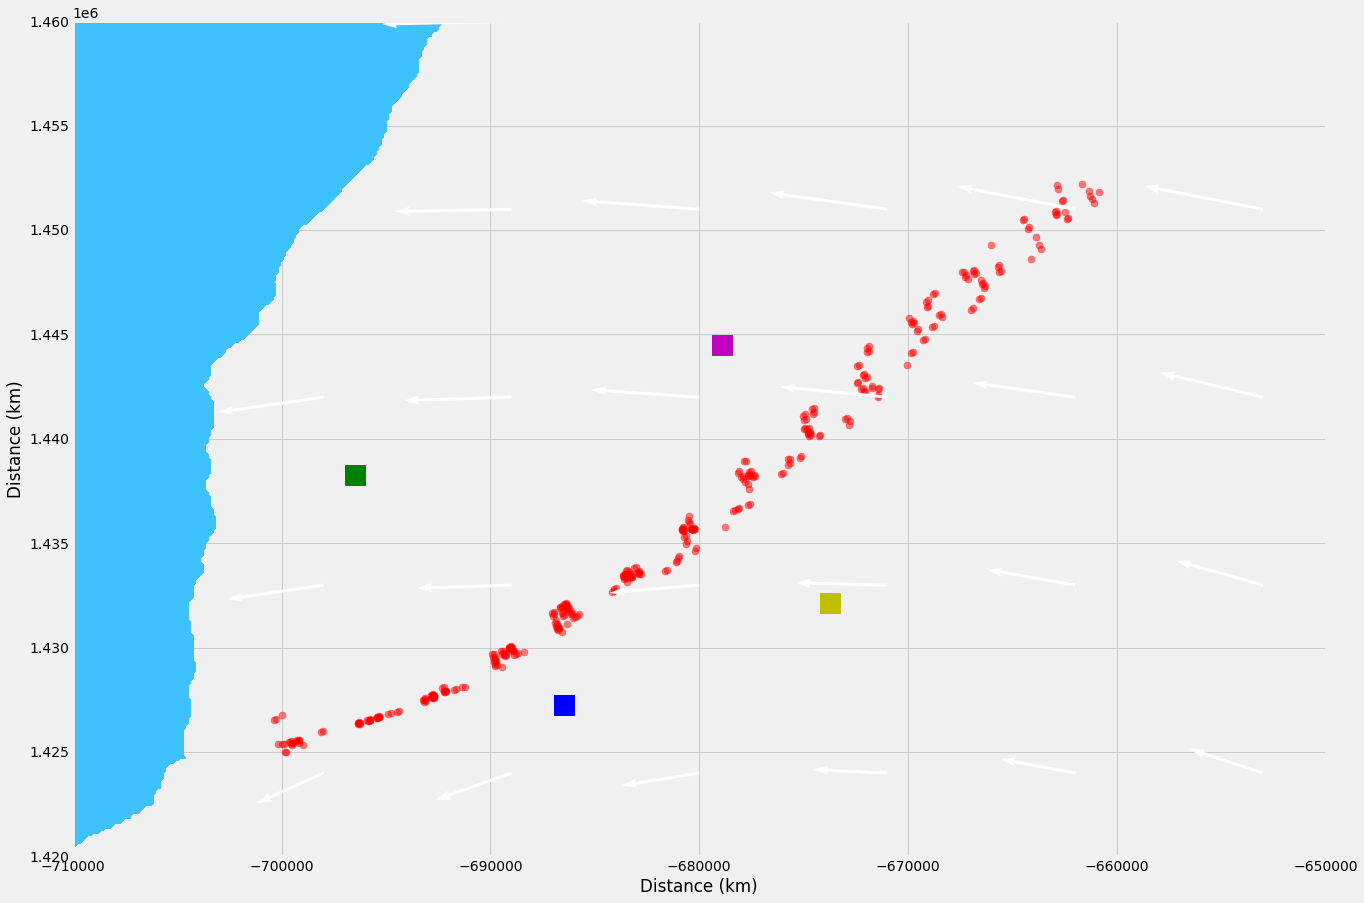

In [12]:
# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]

fig,ax=plt.subplots(figsize=(20,20))

skip=75
plt.scatter(halloween_obs_merged['x-centroid'] ,halloween_obs_merged['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))

c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sg',markersize=20)
plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sb',markersize=20)
plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sm',markersize=20)
plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',markersize=20)
plt.axis('image')
plt.ylim(window_y_halloween)
plt.xlim(window_x_halloween)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
# plt.plot(box_x,box_y)
plt.xlim(-710000,-650000)
plt.ylim(1420000,1460000)

plt.show()

### Calculate rift widths and axis angles

In [13]:
transformer_ps2latlon = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation_new(pt,x,y):
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest == 0:
        #print(closest)
        #the closest is the first point of the rift, so must be (c to c+1)
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        [latc2,longc2] = transformer_ps2latlon.transform( x[closest+1] , y[closest+1] )
        fwd_azimuth,back_azimuth,distance = geodesic.inv(longc1, latc1, longc2, latc2)
    elif closest == len(x)-1:
        #print(closest-1)
        #the closest is the last point of the rift, so must be previous (c-1 to c)
        [latp1,longp1] = transformer_ps2latlon.transform( x[closest-1] , y[closest-1] )
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        fwd_azimuth,back_azimuth,distance = geodesic.inv(longp1, latp1, longc1, latc1)
    else:
        #the closest is not the first or last, so could be (c-1 to c) or (c to c+1)
        #lat long of rift segments surrounding the closest, and the point
        [latp1,longp1] = transformer_ps2latlon.transform( x[closest-1] , y[closest-1] )
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        [latc2,longc2] = transformer_ps2latlon.transform( x[closest+1] , y[closest+1] )
        [latpt,longpt] = transformer_ps2latlon.transform( pt.x , pt.y )
        fwd_azimuth_prev,back_azimuth_prev,distance_prev = geodesic.inv(longp1, latp1, longc1, latc1)
        fwd_azimuth_clo,back_azimuth_clo,distance_clo = geodesic.inv(longc1, latc1, longc2, latc2)
        fwd_azimuth_pt,back_azimuth_pt,distance_pt = geodesic.inv(longc1, latc1, longpt, latpt)
        new_zero = np.mean([back_azimuth_prev,fwd_azimuth_clo])
        new_zero_pt = fwd_azimuth_pt - new_zero
        if new_zero_pt > 0:
            #print(closest)
            fwd_azimuth = fwd_azimuth_clo
        elif new_zero_pt < 0:
            #print(closest-1)
            fwd_azimuth = fwd_azimuth_prev 
    return fwd_azimuth

def estimate_local_rift_orientation_xy_new(pt,x,y):
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest == 0:
        #print(closest)
        #the closest is the first point of the rift, so must be (c to c+1)
        dx = x[closest+1] - x[closest]
        dy = y[closest+1] - y[closest]
        fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
    elif closest == len(x)-1:
        #print(closest-1)
        #the closest is the last point of the rift, so must be previous (c-1 to c)
        dx = x[closest] - x[closest-1]
        dy = y[closest] - y[closest-1]
        fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
    else:
        #the closest is not the first or last, so could be (c-1 to c) or (c to c+1)
        #lat long of rift segments surrounding the closest, and the point
        [latp1,longp1] = transformer_ps2latlon.transform( x[closest-1] , y[closest-1] )
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        [latc2,longc2] = transformer_ps2latlon.transform( x[closest+1] , y[closest+1] )
        [latpt,longpt] = transformer_ps2latlon.transform( pt.x , pt.y )
        fwd_azimuth_prev,back_azimuth_prev,distance_prev = geodesic.inv(longp1, latp1, longc1, latc1)
        fwd_azimuth_clo,back_azimuth_clo,distance_clo = geodesic.inv(longc1, latc1, longc2, latc2)
        fwd_azimuth_pt,back_azimuth_pt,distance_pt = geodesic.inv(longc1, latc1, longpt, latpt)
        new_zero = np.mean([back_azimuth_prev,fwd_azimuth_clo])
        new_zero_pt = fwd_azimuth_pt - new_zero
        if new_zero_pt > 0:
            #print(closest)
            dx = x[closest+1] - x[closest]
            dy = y[closest+1] - y[closest]
            fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
        elif new_zero_pt < 0:
            #print(closest-1)
            dx = x[closest] - x[closest-1]
            dy = y[closest] - y[closest-1]
            fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
    return fwd_azimuth
    
    
    


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []

for index, row in halloween_obs_merged.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy_new(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - halloween_obs_merged['azimuth']))) * halloween_obs_merged['width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - halloween_obs_merged['azimuth']))) * halloween_obs_merged['non-iceberg-width']

# These are the angles of the rift axis
halloween_obs_merged['rift-angle'] = pd.Series(np.array(azimuth), index=halloween_obs_merged.index)
halloween_obs_merged['rift-angle-xy'] = pd.Series(np.array(azimuth_xy), index=halloween_obs_merged.index)
halloween_obs_merged['actual-width'] = pd.Series(np.array(actual_width), index=halloween_obs_merged.index)
halloween_obs_merged['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=halloween_obs_merged.index)


### Perform advection correction
At each time-step: 1) add new observations, 2) advect old observations, 3) merge observations if they are close enough

In [14]:
time_vector = np.sort(np.unique(halloween_obs_merged.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([]),'aw':np.array([]),
                             'anibw':np.array([]),'rgtr':np.array([])})

for i,t in enumerate(time_vector):
    new_obs = halloween_obs_merged[halloween_obs_merged['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y'])
        vy_new = vy_interp(state_vector['x'],state_vector['y'])
        
        # Calculate strain rates
        e11 =  vx_x(state_vector['x'],state_vector['y']) 
        e12 = (  vx_y(state_vector['x'],state_vector['y']) 
              +  vy_x(state_vector['x'],state_vector['y']) ) / 2
        e22 =  vy_y(state_vector['x'],state_vector['y']) 
        
        if state_vector['x'].size > 1:
            vx_new = np.diag( vx_new )
            vy_new = np.diag( vy_new )
            e11 = np.diag ( e11 )
            e12 = np.diag ( e12 )
            e22 = np.diag ( e22 )
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
        state_vector['aw'] = state_vector['aw']* (1 + dt * dw )
        state_vector['anibw'] = state_vector['anibw']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a", "actual-width": "aw",
                                       "actual-non-iceberg-width": "anibw", "rgt": "rgtr"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a","aw","anibw","rgtr"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))


0. Found 1 new observations at time 2018-10-16 17:43:10.150777+00:00 with dt=inf
1. Found 5 new observations at time 2018-10-17 04:36:21.159767+00:00 with dt=0.001241888134395518
2. Found 4 new observations at time 2018-10-21 04:27:52.728882+00:00 with dt=0.010935291945997162
3. Found 6 new observations at time 2018-11-10 16:27:49.994267+00:00 with dt=0.056125854481487825
4. Found 5 new observations at time 2018-11-15 03:12:21.336990+00:00 with dt=0.012176824052621238
5. Found 5 new observations at time 2018-11-19 03:03:53.408036+00:00 with dt=0.010935307851230765
6. Found 2 new observations at time 2018-12-13 14:55:15.840583+00:00 with dt=0.06706094356183612
7. Found 5 new observations at time 2018-12-14 01:48:05.538331+00:00 with dt=0.001241212821887596
8. Found 6 new observations at time 2019-01-07 13:39:44.483041+00:00 with dt=0.06706146680070728
9. Found 2 new observations at time 2019-02-05 12:15:56.432384+00:00 with dt=0.07923834351607854
10. Found 5 new observations at time 201

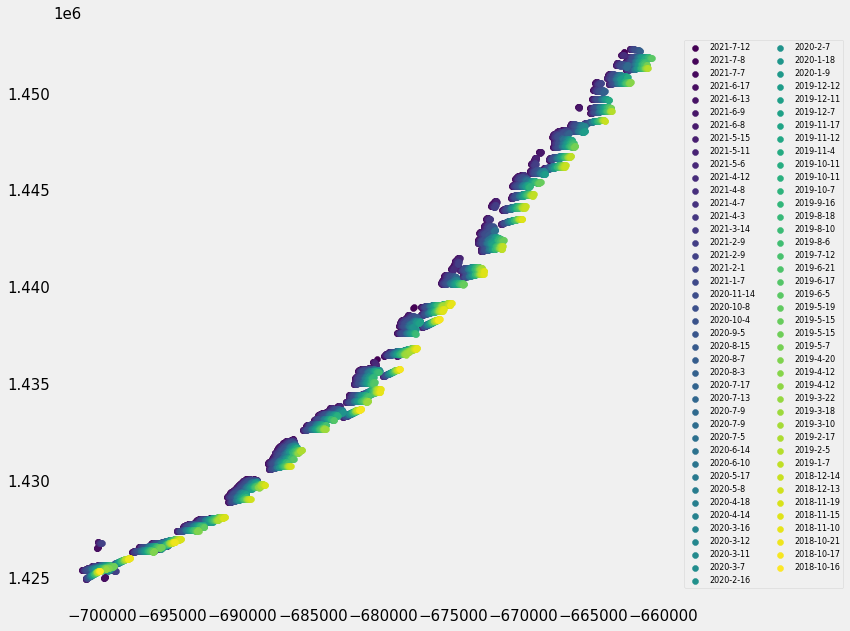

In [15]:
fig,ax = plt.subplots(figsize=(10,10))

color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x'],item['y'],color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, prop={'size': 8})
plt.grid()

plt.show()

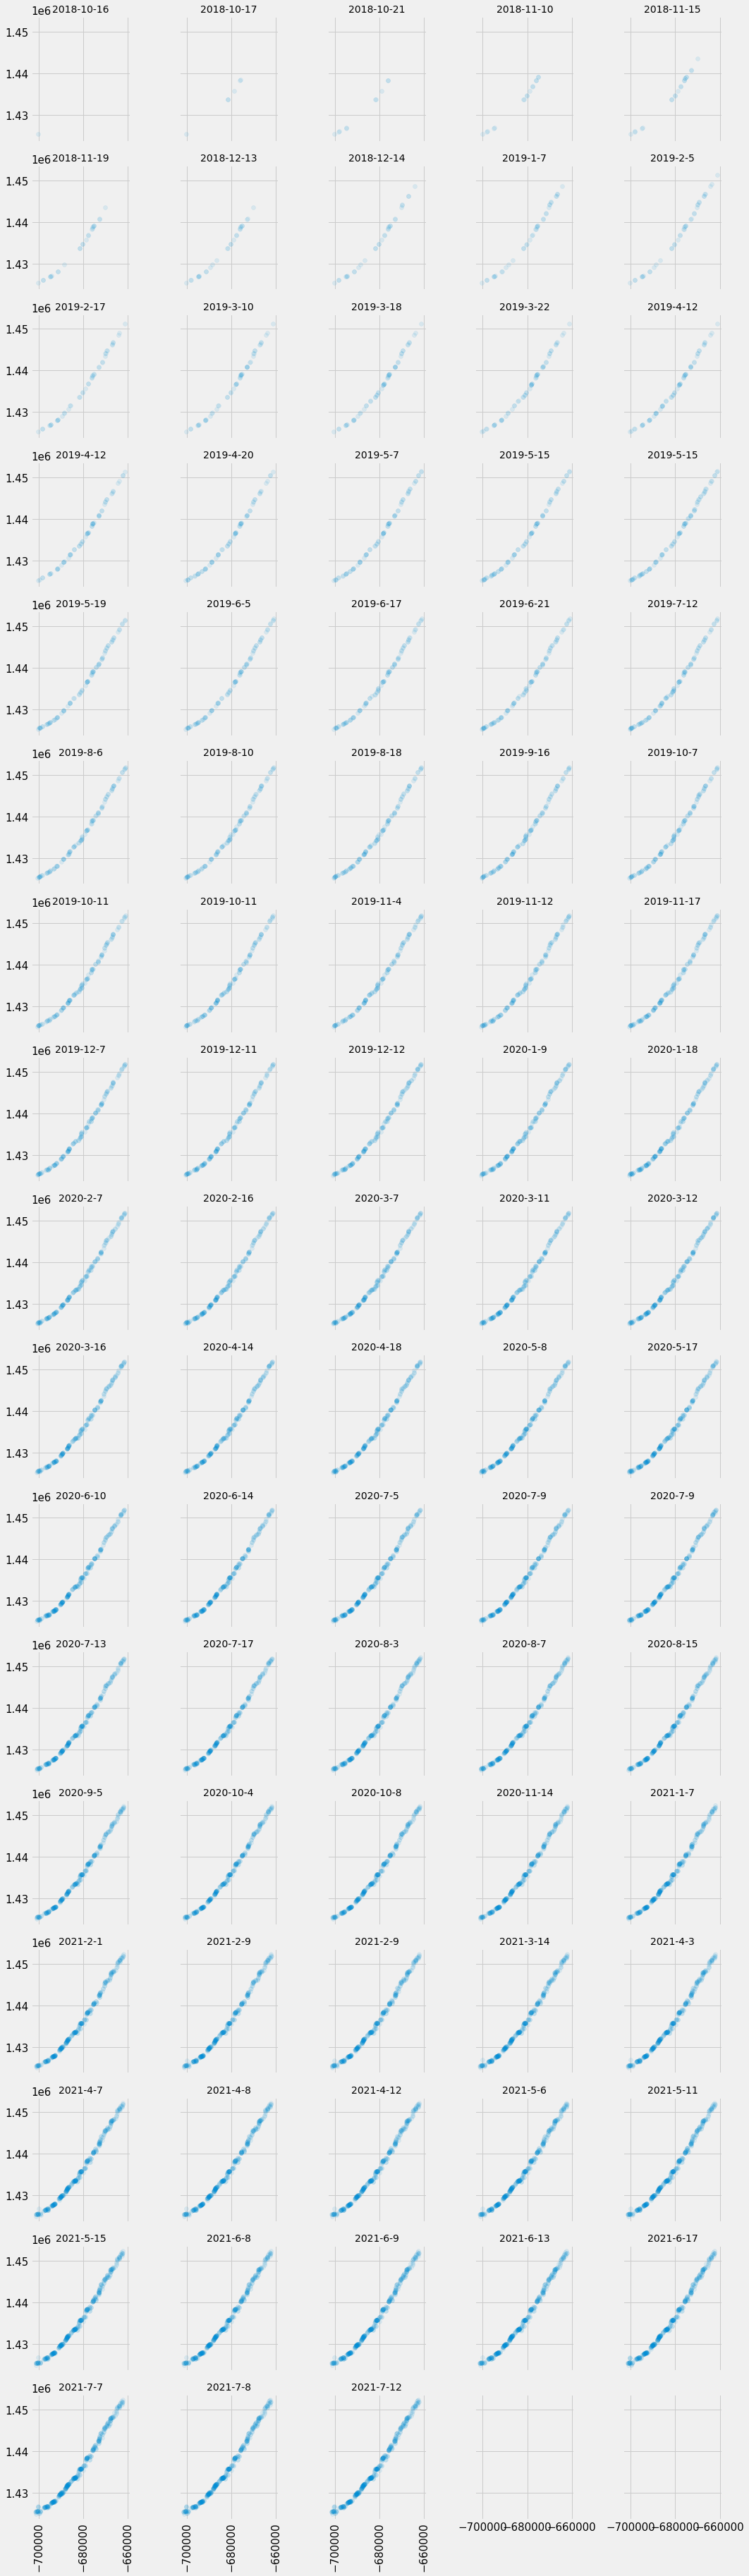

In [16]:
fig,ax = plt.subplots(17, 5,sharex='all', sharey='all',figsize=(15,51))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    plt.subplot(17,5,1+i)
    plt.scatter(item['x'],item['y'],alpha=0.1)
    plt.title('%d-%d-%d'%(t.year,t.month,t.day),fontsize=14)
    plt.xticks(rotation = 90)
plt.tight_layout()

plt.show()

In [17]:
latest = list_of_state_vectors[-1]
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
times_h = halloween_obs_merged['time'].apply(lambda x: (x- latest.iloc[0]['t']).days).values

#print(latest)

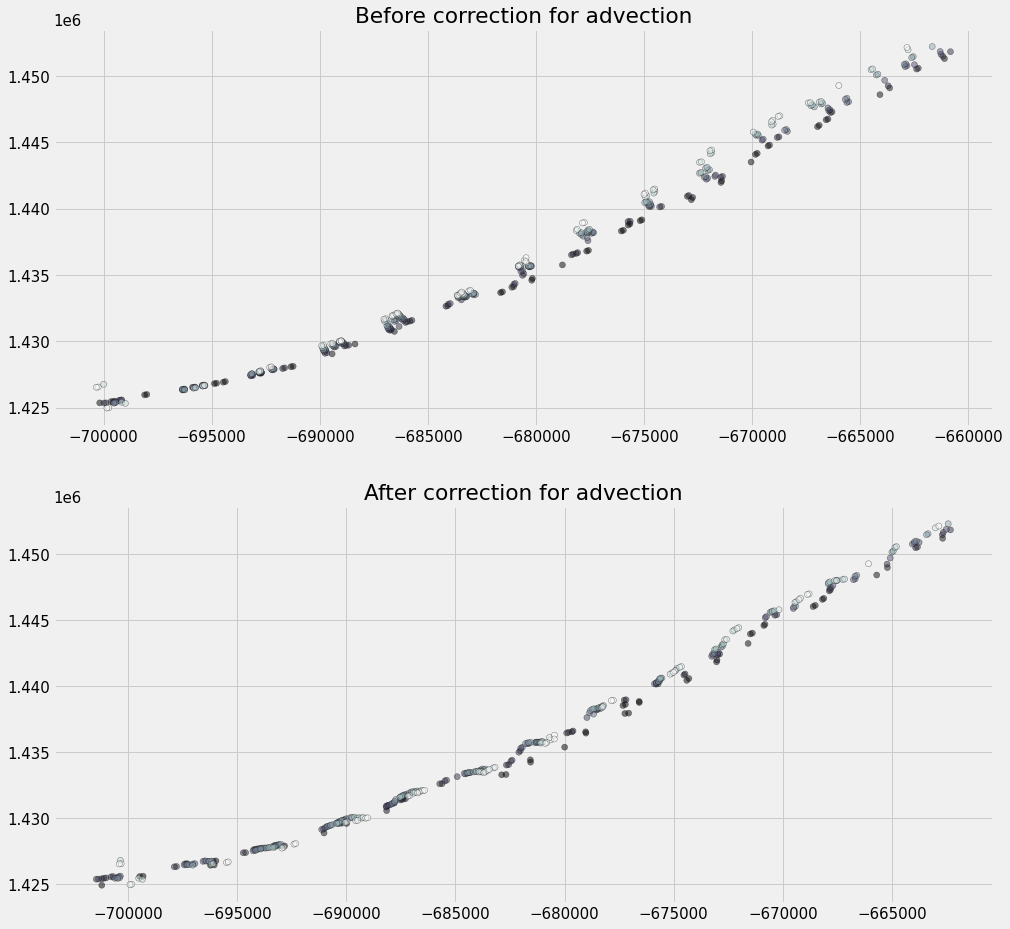

In [18]:
plt.subplots(2,1,figsize=(15,15))

ax=plt.subplot(2,1,1)
c=ax.scatter(halloween_obs_merged['x-centroid'],halloween_obs_merged['y-centroid'],c=times_h,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('Before correction for advection')

ax=plt.subplot(2,1,2)
c=ax.scatter(latest['x'],latest['y'],c=times,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('After correction for advection')

plt.show()

### Rift measurement from Satellite imagery
rift widths along rgts from Landsat-8 image from 2018-10-14, defining initial rift dimensions at the time of first ICESat-2 observation

In [19]:
LS8_obs_20181014 = {
    "rgt": [1289,1289,\
            718,718,718,718,\
            344,344,344,344,344,344,\
            1160,1160,1160,1160,1160,1160,\
            786,786,786,786,786,786,\
            215,215,215,215,215,215,\
            1228,1228,1228,1228,1228,1228,\
            657,657,657,657,657,657,\
            283,283,283,283,283,283,\
            1099,1099,1099,1099,1099,1099,\
            725,725,725,725,725,725,\
            154,154,154,154,154,154,\
            1167,1167,1167,1167,1167,1167,\
            596,596,596,596,596,596,\
            222,222,\
            1038,1038],
    "laser": ["1l","1r",\
              "2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "1l","1r","2l","2r","3l","3r",\
              "3l","3r",\
              "1l","1r"],
    "centroid_lon": [-26.1549,-26.1514,\
                     -26.1256,-26.1290,-25.9999,-26.0032,\
                     -25.9020,-25.8986,-26.0085,-26.0185,-26.1396,-26.1362,\
                     -25.9836,-25.9868,-25.8252,-25.8254,-25.7375,-25.7408,\
                     -25.6424,-25.6389,-25.7653,-25.7619,-25.8869,-25.8834,\
                     -25.7225,-25.7257,-25.6020,-25.6052,-25.4830,-25.4862,\
                     -25.3790,-25.3753,-25.5008,-25.4974,-25.6260,-25.6335,\
                     -25.4672,-25.4705,-25.3338,-25.3518,-25.2304,-25.2336,\
                     -25.1038,-25.1049,-25.2345,-25.2309,-25.3618,-25.3575,\
                     -25.2153,-25.2185,-25.0768,-25.1005,-24.9804,-24.9837,\
                     -24.8342,-24.8305,-24.9651,-24.9614,-25.0904,-25.0868,\
                     -24.9644,-24.9676,-24.8517,-24.8550,-24.7339,-24.7371,\
                     -24.5647,-24.5610,-24.6906,-24.6870,-24.8164,-24.8130,\
                     -24.7176,-24.7208,-24.6007,-24.6040,-24.4847,-24.4879,\
                     -24.5468,-24.5427,\
                     -24.4683,-24.4714],
    "centroid_lat": [-75.4599,-75.4599,\
                     -75.4613,-75.4612,-75.4674,-75.4675,\
                     -75.4703,-75.4702,-75.4667,-75.4672,-75.4607,-75.4608,\
                     -75.4678,-75.4678,-75.4786,-75.4761,-75.4718,-75.4718,\
                     -75.4704,-75.4702,-75.4720,-75.4720,-75.4717,-75.4717,\
                     -75.4708,-75.4710,-75.4686,-75.4689,-75.4641,-75.4642,\
                     -75.4643,-75.4639,-75.4643,-75.4643,-75.4698,-75.4696,\
                     -75.4636,-75.4636,-75.4623,-75.4589,-75.4530,-75.4532,\
                     -75.4456,-75.4455,-75.4532,-75.4529,-75.4619,-75.4606,\
                     -75.4509,-75.4511,-75.4473,-75.4453,-75.4375,-75.4376,\
                     -75.4219,-75.4214,-75.4373,-75.4367,-75.4432,-75.4429,\
                     -75.4372,-75.4374,-75.4230,-75.4231,-75.4172,-75.4174,\
                     -75.4058,-75.4054,-75.4134,-75.4131,-75.4206,-75.4205,\
                     -75.4162,-75.4163,-75.4089,-75.4091,-75.4004,-75.4007,\
                     -75.4041,-75.4031,\
                     -75.3991,-75.3994],
    "total_width": [201,199,\
                    263,271,408,396,\
                    431,432,318,338,216,235,\
                    432,432,632,633,488,482,\
                    456,461,486,475,654,627,\
                    669,654,603,579,422,433,\
                    418,410,430,435,469,502,\
                    404,397,497,483,627,630,\
                    288,303,671,671,622,646,\
                    367,373,265,292,261,269,\
                    289,293,292,392,355,323,\
                    235,265,239,225,165,150,\
                    125,130,232,191,211,214,\
                    185,177,121,132,88,82,\
                    133,198,\
                    75,75],
    "non-iceberg-width": [201,199,\
                    263,271,408,396,\
                    431,432,318,338,216,235,\
                    432,432,447,451,488,482,\
                    456,461,486,475,390,414,\
                    457,444,414,427,422,433,\
                    418,410,430,435,469,502,\
                    404,397,497,483,310,327,\
                    288,303,360,353,622,646,\
                    367,373,265,292,261,269,\
                    289,293,292,272,355,323,\
                    235,265,239,225,165,150,\
                    125,130,232,191,211,214,\
                    185,177,121,132,88,82,\
                    133,143,\
                    75,75],
    "comment": ["-","-",\
                "-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","-","bridge","bridge","-","-",\
                "-","-","-","-","bridge","bridge",\
                "bridge","bridge","bridge","bridge","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","bridge","bridge",\
                "-","-","bridge","bridge","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","bridge","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","bridge",\
                "-","-"],
    "azimuth": [-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -171.1,-171.1,\
                -8.9,-8.9]
}
                       
LS8_obs_20181014 = pd.DataFrame(LS8_obs_20181014)
#display(LS8_obs_20181014)


### transform into rift perpendicular geometry

In [20]:
transformer_latlon2ps = Transformer.from_crs("EPSG:4326","EPSG:3031")

Ecentroid = []
Ncentroid = []
for index, row in LS8_obs_20181014.iterrows():
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)

LS8_obs_20181014["x-centroid"] = Ecentroid
LS8_obs_20181014["y-centroid"] = Ncentroid

LS8_obs_20181014 = gpd.GeoDataFrame(LS8_obs_20181014, geometry=gpd.points_from_xy(LS8_obs_20181014["x-centroid"],LS8_obs_20181014["y-centroid"]))

transformer_ps2latlon = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

azimuth = []

for index, row in LS8_obs_20181014.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - LS8_obs_20181014['azimuth']))) * LS8_obs_20181014['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - LS8_obs_20181014['azimuth']))) * LS8_obs_20181014['non-iceberg-width']

LS8_obs_20181014['rift-angle'] = pd.Series(np.array(azimuth), index=LS8_obs_20181014.index)
LS8_obs_20181014['actual-width'] = pd.Series(np.array(actual_width), index=LS8_obs_20181014.index)
LS8_obs_20181014['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=LS8_obs_20181014.index)

#display(LS8_obs_20181014)


### GPS opening rate
from Figures_4_5_6_S1.ipynb

In [21]:
GNSS_west_opening_rate = 254.5
GNSS_east_opening_rate = 175.4

### Combine with simple model of rift opening

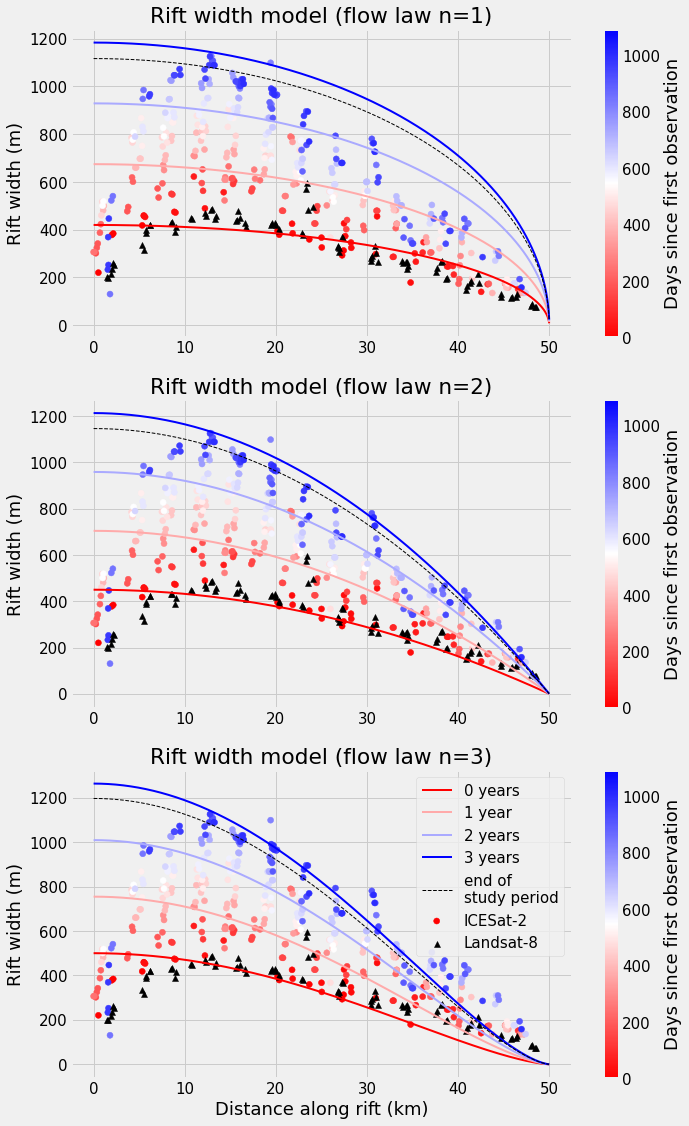

In [22]:
xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']

sat_dist = np.sqrt( (LS8_obs_20181014['x-centroid'].to_numpy()-xmin)**2 + (LS8_obs_20181014['y-centroid'].to_numpy()-ymin)**2 )
sat_width = LS8_obs_20181014["actual-non-iceberg-width"]

dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )

rift_len = 50
xx = np.arange(0,rift_len,0.01)

tmax = max(times)
rate = GNSS_west_opening_rate / 365 # hh00 and tt05
wmax = rate * tmax

w1 = rate * 1 * 365 
w2 = rate * 2 * 365
w3 = rate * 3 * 365

# rift width at first observation (2014-10-14)
#wmax_init = 450
w_init = [420, 450, 500]

r = np.sqrt(rift_len**2 - xx**2)


fig = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)

for i in (1,2,3):
    ax=plt.subplot(3,1,i)
    n=i
    pl_in = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)),'-',linewidth=2,color=(1,0,0),label='0 years')
    pl_t1 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w1 * ((r/rift_len)**n)),'-',linewidth=2,color=(1,2/3,2/3),label='1 year')
    pl_t2 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w2 * ((r/rift_len)**n)),'-',linewidth=2,color=(2/3,2/3,1),label='2 years')
    pl_t3 = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (w3 * ((r/rift_len)**n)),'-',linewidth=2,color=(0,0,1),label='3 years')
    pl_sm = ax.plot(xx,(w_init[n-1] * ((r/rift_len)**n)) + (wmax * ((r/rift_len)**n)),'--',linewidth=1,color=(0,0,0),label='end of\nstudy period')
    
    # plot width ignoring icebergs/peninsulas/bridges
    pl_is = ax.scatter(dist/1e3,latest['anibw'],c=times,cmap='bwr_r',vmin=0,vmax=3*365,\
                 alpha=1,label="ICESat-2") #label=latest['t'],edgecolors='k'

    cbar=plt.colorbar(pl_is)
    
    # plot Landsat-8 2018-10-14 widths
    pl_ls = ax.scatter(sat_dist/1e3,sat_width,c='k',marker='^',label="Landsat-8")
    
    
    pl_all =[pl_ls, pl_in, pl_t1, pl_t2, pl_t3, pl_is]
    
    cbar.set_label('Days since first observation')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)
ax.set_xlabel('Distance along rift (km)')
ax.legend(loc = 'upper right')

plt.show()